# Exercise 1

We decided to first aggregate the data per player instead of working with dyads because it seemed more appropriate knowing the task that was given. Then we used a Random forest regressor as our model, this is the case because the observations are not some categorical classes that are not related to one another. Indeed the observations are a discretization of the darkness of the skin of a player which is much simpler for a human to rate than to give a continuous grade (like 2.1235 instead of 2.1236).
By applying cross-validation to our model we reduce overfitting of the model, and the results obtained with MSE are still quite good. 
At the end of the notebook we plotted the fifteen most important features in the dataset.


Steps of the exercise:
- Read the csv file
- Drop meaningless features that do not give us information about a player's skin color (such as 'player' and 'birthday')
- In the first iteration of the exercise we do not use the features that are associated to the 'racistness' of the referees
- We aggregate the data set by player, such that each row contains a player and the sum of features for goals, vitories etc... But we change those features by the number of those per game, which gives more insight than just the raw data. We also keep categorical features such as leagueCountry
- We normalize the data to remove some bias induced
- Drop some outliers
- Encode the categorical data with a OneHotEncoder
- Apply cross-validation on our Random Forest Regressor
- Plot features importance

In [87]:
import pandas as pd            
import numpy as np             
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans, SpectralClustering
import itertools
%matplotlib inline

In [3]:
# Read csv
df = pd.read_csv('CrowdstormingDataJuly1st.csv')
# Drop meaningless columns, we don't need the whole player name nor the birthday
df.drop(['player','birthday'], 1, inplace=True)
# Drop dyads where there are no photoID
df.dropna(axis=0, subset=['photoID'], inplace=True)
df.drop('photoID', 1, inplace=True)
# Drop dyads where there are no rating
df.dropna(axis=0, how='all', subset=['rater1', 'rater2'], inplace=True)

In [4]:
# First, try without 'racist data'
df.drop(['refNum','refCountry','Alpha_3','meanIAT','nIAT','seIAT','meanExp','nExp','seExp'], 1, inplace=True)

In [5]:
# Need to sum for the aggregation
sumAggIndexes = ['playerShort', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards','yellowReds', 'redCards']
dfSumAgg = df[sumAggIndexes]
aggregatedWithSum = dfSumAgg.groupby('playerShort').sum()

# No sum for aggregation
dfIdentityAgg = df[['playerShort', 'club', 'leagueCountry', 'height', 'weight',
       'position', 'rater1', 'rater2']]
identity = lambda x: x.iloc[0]
aggregatedWithIdentity = dfIdentityAgg.groupby('playerShort').agg(identity)

# Concatenate
dfd = pd.concat([aggregatedWithIdentity, aggregatedWithSum], axis=1)


In [6]:
# Normalize:

# vitories, defeats, ties, goals, cards -> 
#   for each player x: x._/x.games

colsToNorm = ['victories', 'ties', 'defeats', 'goals', 'yellowCards','yellowReds', 'redCards']
ds = []
for c in colsToNorm:
    col = []
    for i in dfd.index:
        col.append(dfd[c].loc[i]/dfd['games'].loc[i])
    ds.append(pd.DataFrame(columns=[c], index=dfd.index, data=col))
 
# Normalize the games column
colsToNorm.append('games')
meanGames = dfd['games'].mean()
stdGames = dfd['games'].std()

ds.append(pd.DataFrame(columns=['games'], index=dfd.index, data=dfd['games'].map(lambda x : (x-meanGames)/stdGames)))

dfd = pd.concat([pd.concat(ds,axis=1), dfd.drop(colsToNorm, axis=1)] ,axis=1)

In [7]:
# Deal with NaN in weight and height
# There are only few missing data so we can fill them with the mean of the column without
# inducing to much bias in the data

ws = dfd['weight']
meanW = ws.dropna().mean()
dfd['weight'].fillna(meanW, inplace=True)
stdW = dfd['weight'].std()
dfd['weight'] = dfd['weight'].apply(lambda x: (x-meanW)/stdW)

hs = dfd['height']
meanH = hs.dropna().mean()
dfd['height'].fillna(meanH, inplace=True)
stdH = dfd['height'].std()
dfd['height'] = dfd['height'].apply(lambda x: (x-meanH)/stdH)


In [8]:
# Remove players which are classified really differently (only 2)
diff = abs(dfd['rater1']-dfd['rater2'])
diff.value_counts()
# rm outliers
dfd.drop(diff[diff == 0.50].index, inplace=True)

In [9]:
# This is the target/observation
target = (dfd['rater1']+dfd['rater2'])/2
# This is the data
data = dfd.drop(['rater1', 'rater2'], axis=1)

In [10]:
# Encode the categorical features
le = preprocessing.LabelEncoder()
clubEncoded = pd.Series(index=data.index, data=le.fit_transform(data.club))
leagueCountryEncoded = pd.Series(index=data.index, data=le.fit_transform(data.leagueCountry))
# Encode the 'position', it has NaN values, so we handle them by replacing them
# by the most frequent label
position = data['position']
posFiltered = position.dropna()
posNan = position[position.isnull()]
posFilEnc = le.fit_transform(posFiltered)
posFilEncAsSerie = pd.Series(index=posFiltered.index, data=posFilEnc)
concat = pd.concat([posFilEncAsSerie, posNan])
positionWithNan = concat.sort_index()

imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=1)
positionEncoded = pd.Series(index=positionWithNan.index, data=imp.fit_transform(positionWithNan)[0].astype(int))

# Dataframe with categorical data encoded as int
dataEncoded = pd.concat([clubEncoded, positionEncoded, leagueCountryEncoded],axis=1)
dataEncoded.columns = ['club', 'position', 'leagueCountry']

C:\Users\bapti\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [11]:
# One hot encoder
enc = preprocessing.OneHotEncoder()
enc.fit(dataEncoded)
oneHotEncodedData = enc.transform(dataEncoded).toarray()
#oneHotEncodedData.astype()
dfEncoded = pd.DataFrame(index=dataEncoded.index, data=oneHotEncodedData).astype(int)

In [12]:
# New data with categorical data encoded
dff = pd.concat([data.drop(['club','position','leagueCountry'], axis=1), dfEncoded], axis=1)
dff.head(2)

,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,games,height,weight,...,103,104,105,106,107,108,109,110,111,112
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,0.377676,0.273700,0.348624,0.013761,0.029052,0.0,0.000000,2.935828,-0.006568,-0.713278,...,0,0,0,0,0,0,1,0,0,0
aaron-hunt,0.419643,0.217262,0.363095,0.184524,0.125000,0.0,0.002976,0.705694,0.141876,-0.429923,...,0,0,0,0,0,0,0,0,1,0


In [13]:
# cross validate a random forest regressor
clf = RandomForestRegressor(n_estimators=50)
cross_val_score(clf, dff, target, cv=10, scoring='neg_mean_squared_error', n_jobs=-1).mean()

-0.077692278978584509

Feature ranking:
1. feature 7 (0.096687), games
2. feature 4 (0.086441), yellowCards
3. feature 3 (0.078531), goals
4. feature 2 (0.077028), defeats
5. feature 0 (0.075015), victories
6. feature 120 (0.065818), 110
7. feature 1 (0.065629), ties
8. feature 9 (0.063298), weight
9. feature 6 (0.054015), redCards
10. feature 8 (0.053034), height
11. feature 5 (0.047630), yellowReds
12. feature 119 (0.014781), 109
13. feature 109 (0.009940), 99
14. feature 111 (0.009551), 101
15. feature 121 (0.009430), 111


(-1, 15)

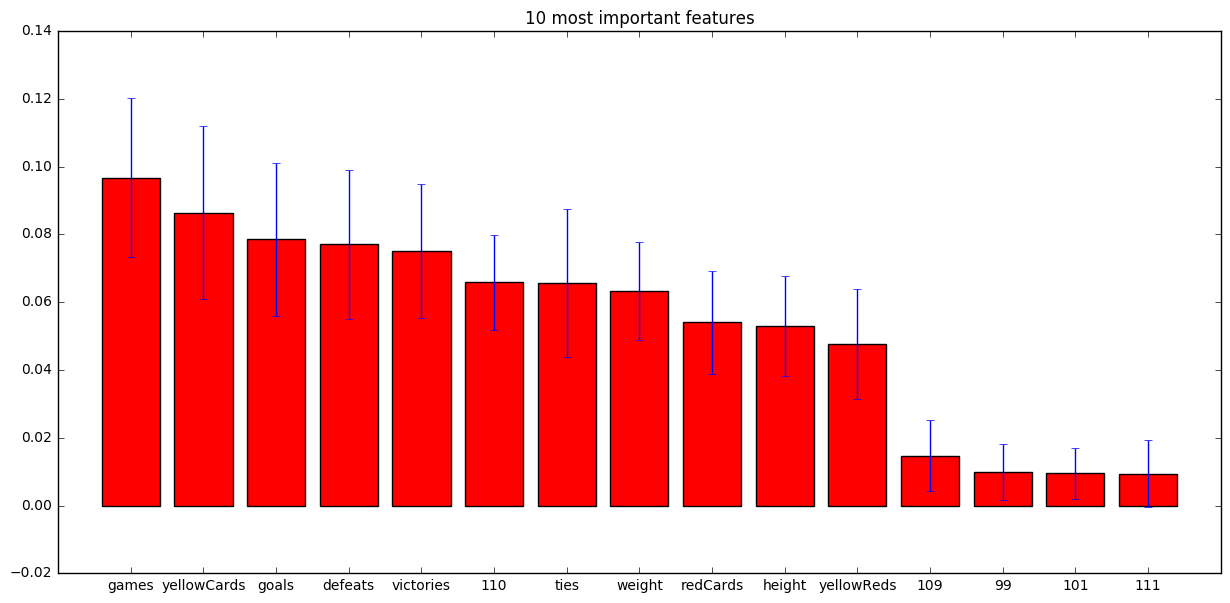

In [18]:
forest = clf
X = dff
y = target
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(15):
    print("%d. feature %d (%f), %s" % (f + 1, indices[f], importances[indices[f]], X.columns[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,7))
plt.title("10 most important features")
plt.bar(range(15), importances[indices[0:15]],
       color="r", yerr=std[indices[0:15]], align="center")
plt.xticks(range(15), X.columns[indices[0:15]])
plt.xlim([-1, 15])

---

# Exercise 2

In [132]:
dffWithTarget = pd.concat([dff, target], axis=1)
km = (n_clusters=2)

dff_temp = dff
km.fit(dff_temp)
labels = km.labels_ 
ss = silhouette_score(dff_temp, labels)
err1 = pow(target - labels, 2).mean()
err2 = pow(target - (labels+1)%2, 2).mean()
maxSS = 1
maxSS = max(maxSS, silhouette_score(dff_temp, labels))
print('silhouette:', ss, 'score:', min(err1, err2))

silhouette: 0.0992626967545 score: 0.2803320435881238


## NEED TO USE TRAIN/TEST

In [136]:
indicesToUse = indices[0:10]
minErr = 1
maxSS = -1
for i in range(5,11):
    c = itertools.combinations(indicesToUse, i)
    for ic in c:
        dff_temp = dff[dff.columns[list(ic)]]
        km.fit(dff_temp)
        labels = km.labels_ 
        err1 = pow(target - labels, 2).mean()
        err2 = pow(target - (labels+1)%2, 2).mean()
        err = min(err1, err2)
        ss = silhouette_score(dff_temp, labels)
        if(err < minErr):
            minErr = err
            errStruc = [i, list(ic), ss, minErr]
        if(ss > maxSS):
            maxSS = ss
            ssStruc = [i, list(ic), maxSS, err]

        
print('DONE')

DONE


In [138]:
print(errStruc)
print(ssStruc)

[5, [4, 3, 2, 0, 120], 0.18715453253316489, 0.77299252778536098]
[5, [4, 2, 120, 1, 6], 0.8495107233990572, 0.1874703885028427]


# TEST CELLS

In [ ]:


d = pd.DataFrame({'A' : ['foo', 'bar', 'foo', 'bar',
                  'foo', 'bar', 'foo', 'foo'],
                  'B' : ['one', 'one', 'two', 'three',
                          'two', 'two', 'one', 'three'],
                  'C' : np.random.randn(8),
                  'D' : np.random.randn(8),
                  'E' : [np.nan,'0','1','0','1','0','1','1'],
                  'F' : [1,2,3,4,5,6,7,8]})
d.set_index('F', inplace=True)

In [ ]:
x = []
for c in d['A']:
    x.append(c)
    
x